# Models and Results

In this notebook we will be experimenting with different **versions** of our models, **evaluating** their performances and **comparing** the results.

We chose two model architectures: `U-Net`and `DeepLabv3`.

The notebook will have the following structure: 
1. Training `U-Net` on unprocessed data
2. Training `U-Net` on processed data where we only keep the roofs on images 
3. Training `U-Net` on processed data where we only keep the roofs and augment the data 
4. Training `DeepLabv3` on processed data where we only keep the roofs on images

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import defaultdict
from PIL import Image, ImageDraw
from typing import Optional
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2

src_path = Path('../src').resolve()  
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from helpers import get_loaders, train_model, metrics
from plotting import visualize_results, plot_losses, compare_model_metrics
from unet import UNet

%load_ext autoreload
%autoreload 2

### Importing the data

Let's start by importing the data, you can start by downloading our dataset from [Kaggle](https://www.kaggle.com/datasets/jeanperbet/ml-project-2-solar-panels?select=roof_images) and adding it to the working directory under the folder name `data`.

We will consider three sets of data:
- **Original images** : unmodified 1000 $\times$ 1000 pixel tiles.
- **Processed images** : processed 1000 $\times$ 1000 pixel tiles where all non-roof pixels were colored in *magenta*.
- **masks** : grayscale 1000 $\times$ 1000 pixel tiles encoding the positions of the solar panels.

In [2]:
ROOT_DIR = "../data/"
images_dir = os.path.join(ROOT_DIR, "images/")
roof_images_dir = os.path.join(ROOT_DIR, "roofs/images/")
labels_dir = os.path.join(ROOT_DIR, "labels/")
weights_dir = os.path.join(ROOT_DIR, "weights/")

image_names = [file for file in os.listdir(images_dir) if file.endswith('.jpg')]

### Splitting the data 

In order to evaluate our model well, we will be segmenting our dataset into three subsets: **train set**, **validation set** and **test set**.  Both trainn and validation sets will be used during the training and the test set will be use dofr the final evaluation of the model in order to compute the performance metrics. 

We chose the following split: $80\%$ for train, $10\%$ for validation and $10\%$ for test.

In [3]:
images_train_loader, images_val_loader, images_test_loader = get_loaders(
    image_names[:10], images_dir, labels_dir, batch_size=2
)
roof_images_train_loader, roof_images_val_loader, roof_images_test_loader = get_loaders(
    image_names[:10], roof_images_dir, labels_dir, batch_size=2
)
print(f"Train data loader size: {len(images_train_loader)}")
print(f"Validation data loader size: {len(images_val_loader)}")
print(f"Test data loader size: {len(images_test_loader)}")

Train data loader size: 4
Validation data loader size: 1
Test data loader size: 1


## Training phase 
### Early stopping
In order to accelerate our training we well be using **early stopping** which is a regularization technique that halts training when the validation performance stops improving, preventing overfitting to the training data. It monitors the loss after each epoch and stops training if no improvement is observed for a specified number of epochs **(patience)** that we set to 3 by default. The best-performing model parameters are saved before performance starts to degrade. This approach is particularly useful as it balances training duration with model performance.

### Training `U-Net` on regular images

To ensure that the models are trained on the best available architecture, we eventually move the computations to a GPU.

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


The following cell is used to train the model. Notice that the last line in the cell saves the weights of the model in the folder **weights**. This is particularly useful since it allows us to train the model only once. 

In case you **don't want to train** the model you can **skip the next cell** and use the **saved weights** in the folder `weights` to initialize a **pre-trained model**.    

Training Epoch 1: 100%|██████████| 4/4 [00:18<00:00,  4.58s/it]


Epoch 1/2, Training Loss: 0.9580


Validation Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Validation Loss: 1.0851
Validation loss improved, saving model...


Training Epoch 2: 100%|██████████| 4/4 [00:16<00:00,  4.03s/it]


Epoch 2/2, Training Loss: 0.5865


Validation Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Validation Loss: 0.9505
Validation loss improved, saving model...
Training complete.


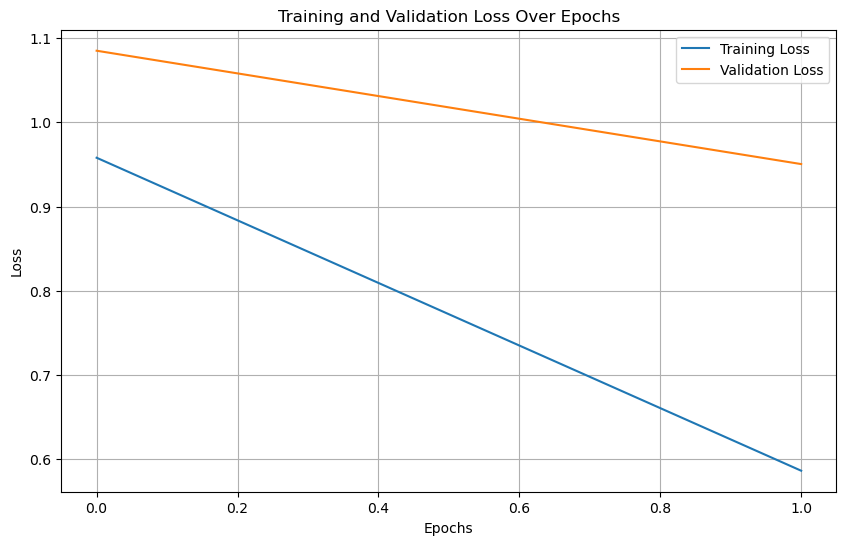

In [5]:
original_model = UNet()
original_train_losses, original_val_losses = train_model(
    model=original_model,
    train_loader=images_train_loader,
    val_loader=images_val_loader,
    device=device,
    criterion=nn.BCELoss(),
    lr=0.0003,
    epochs=2,
    patience=3
)

plot_losses(original_train_losses, original_val_losses)
torch.save(original_model.state_dict(), os.path.join(weights_dir, "unet_original_weights.pth"))

The following cell creates a new model and **loads it** with the **weights of a pretrained model**.

In [6]:
original_model = UNet()
original_model.load_state_dict(torch.load('../data/weights/unet_original_weights.pth'))
original_model.to(device);

Let's now visualise some of the results

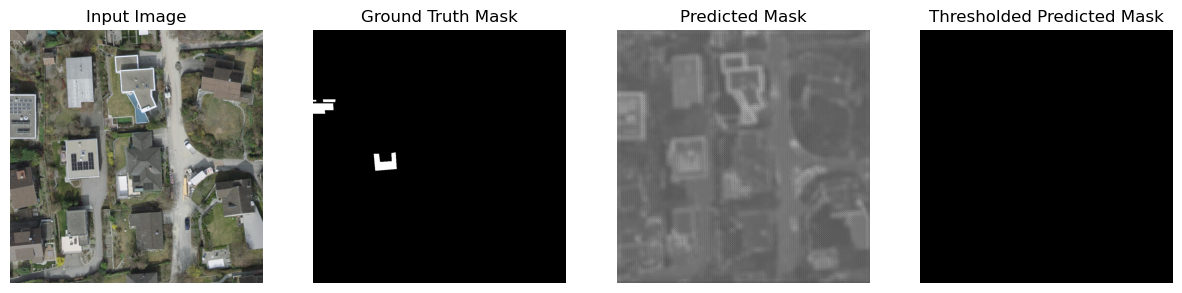

In [7]:
visualize_results(original_model, images_test_loader, idx=0, device=device, threshold=0.3) # set index to 21 before final run

We will now evaluate our model using the following metrics: `accuracy`, `f1`, `precision`, `recall` and `IoU`. `IoU`is the intersection over using (also known as [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)) and is defined as:
$$ 
\text{IoU} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}
$$

In [8]:
original_accuracy, original_f1, original_precision, original_recall, original_iou = (
    metrics(original_model, images_test_loader, device, threshold=0.3)
)

### Training `U-Net` on only roofs images

Our goal here is to reduce the complexity of the data before feeding it the model. Our hypothesis is that **solar panels can only lie on roofs**. Hence we decided to color evry pixel that does not lie on a roof using **magenta**. This way we reduce the complexity of the input data and make the model focus more on the roof based pixels. The corresponding tiles were already generated during the pre-processing phase using the `SOLKAT_DACH.gpkg` file.
The images should look as follows:

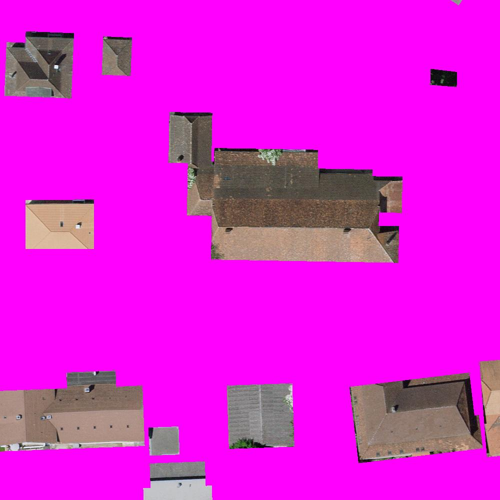

In [9]:
Image.open(roof_images_dir +"/swissimage-dop10_2021_2575.0-1206.0.jpg").resize((500, 500))

As previously, the following cell trains the model. You can **skip it** and run the **cell** just **after** to import a **pre-trained model**.

Training Epoch 1: 100%|██████████| 4/4 [00:15<00:00,  4.00s/it]


Epoch 1/2, Training Loss: 0.6332


Validation Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Validation Loss: 0.7252
Validation loss improved, saving model...


Training Epoch 2: 100%|██████████| 4/4 [00:16<00:00,  4.15s/it]


Epoch 2/2, Training Loss: -1.2044


Validation Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Validation Loss: 4.0009
Validation loss did not improve. Patience counter: 1/3
Training complete.


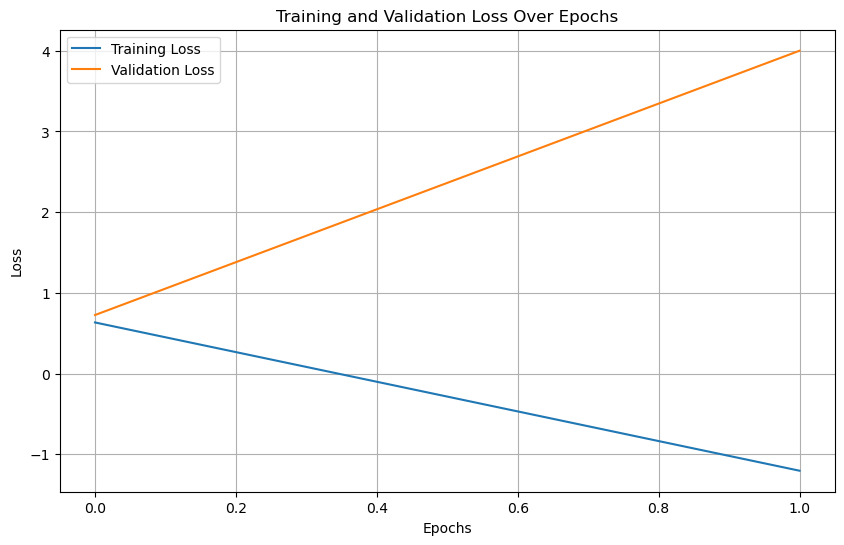

In [10]:
processed_model = UNet()

processed_train_losses, processed_val_losses = train_model(
    model=processed_model,
    train_loader=roof_images_train_loader,
    val_loader=roof_images_val_loader,
    device=device,
    criterion=nn.BCELoss(),
    lr=0.0003,
    epochs=2,
    patience=3
)

plot_losses(processed_train_losses, processed_val_losses)
torch.save(processed_model.state_dict(), '../data/weights/unet_processed_weights.pth')

In [11]:
processed_model = UNet()
processed_model.load_state_dict(torch.load('../data/weights/unet_original_weights.pth'))
processed_model.to(device);

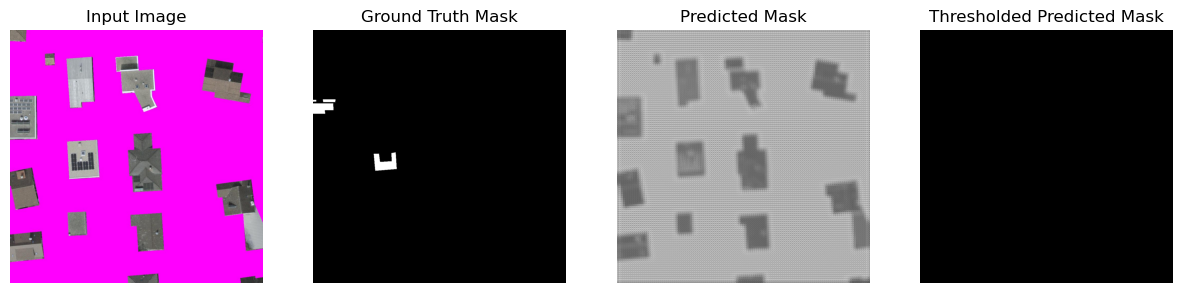

In [12]:
visualize_results(processed_model, roof_images_test_loader,device, idx=0, threshold=0.3) # set index to 21 before final run

In [13]:
roof_accuracy, roof_f1, roof_precision, roof_recall, roof_iou = metrics(processed_model, images_test_loader, device, threshold=0.3)

### Training `U-Net` on augmented, only roof images

During this step we will also be performaing some **data augmentation**. The augmentation will simulate some **realistic inputs** the model might encounter with new data. For this purpose we will be using the library `Albumentation` which allows the application of transforms with a probability $p$ on both images and their labels.

The transform will be a composition of a **rotations** (of angle randomly chosen between $0°$, $90°$, $180°$ and $270°$) a **symmetry** around the **x-axis** and a **symmetry** around the **y-axis**.

In [14]:
transform = A.Compose(
    [
        A.OneOf(
            [
                A.Rotate(limit=(0, 0), p=0.25),
                A.Rotate(limit=(90, 90), p=0.25),
                A.Rotate(limit=(180, 180), p=0.25),
                A.Rotate(limit=(270, 270), p=0.25),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ],
    is_check_shapes=False,
)

Since the transforms are applied during `__getitem__` call of the dataloader, we'll have to define new dataloaders while specifying the trnasforms.

In [15]:
augmented_train_loader, augmented_val_loader, augmented_test_loader = get_loaders(
    image_names[:10], roof_images_dir, labels_dir, batch_size=2, transform=transform
)

Training Epoch 1: 100%|██████████| 4/4 [00:18<00:00,  4.54s/it]


Epoch 1/2, Training Loss: 0.9562


Validation Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Validation Loss: 1.0553
Validation loss improved, saving model...


Training Epoch 2: 100%|██████████| 4/4 [00:19<00:00,  4.98s/it]


Epoch 2/2, Training Loss: -1.4623


Validation Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Validation Loss: 3.9242
Validation loss did not improve. Patience counter: 1/3
Training complete.


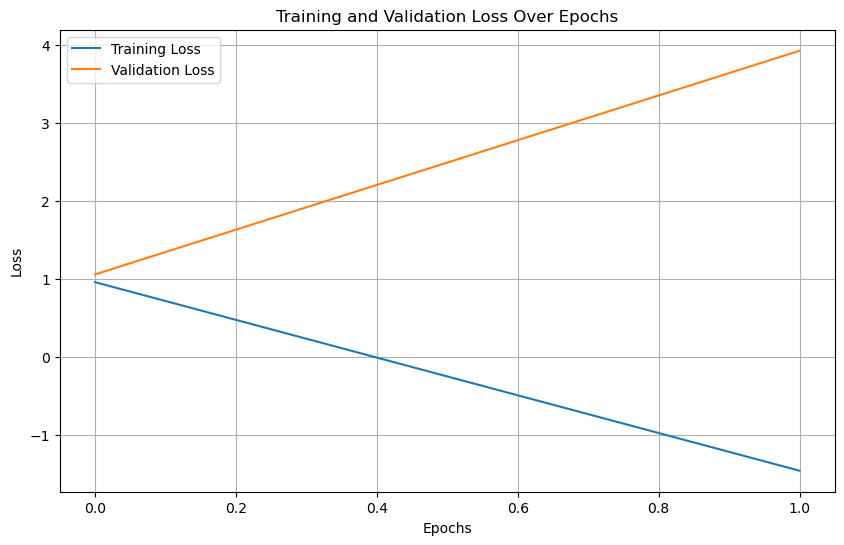

In [16]:
augmented_model = UNet()

augmented_train_losses, augmented_val_losses = train_model(
    model=augmented_model,
    train_loader=augmented_train_loader,
    val_loader=augmented_val_loader,
    device=device,
    criterion=nn.BCELoss(),
    lr=0.0003,
    epochs=2,
    patience=3
)

plot_losses(augmented_train_losses, augmented_val_losses)
torch.save(augmented_model.state_dict(), '../data/weights/unet_augmented_weights.pth')

In [17]:
augmented_model = UNet()
augmented_model.load_state_dict(torch.load('../data/weights/unet_augmented_weights.pth'))
augmented_model.to(device);

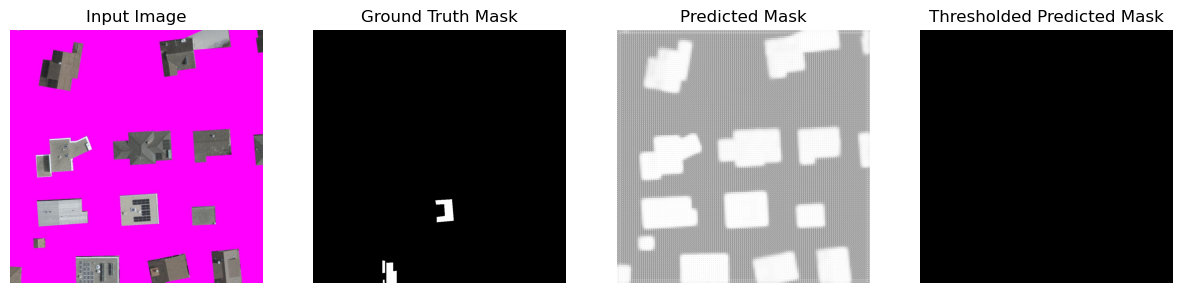

In [18]:
visualize_results(augmented_model, augmented_test_loader, idx=0, device=device, threshold=0.3) # set index to 21 before final run

In [19]:
augmented_accuracy, augmented_f1, augmented_precision, augmented_recall, augmented_iou = metrics(augmented_model, augmented_test_loader, device, threshold=0.3)

## Compare Models 

For the final comparison of  our models we will be primarily focusing in `F1-score` and `IoU`. Let's start by visualizing these results susing bar plots.

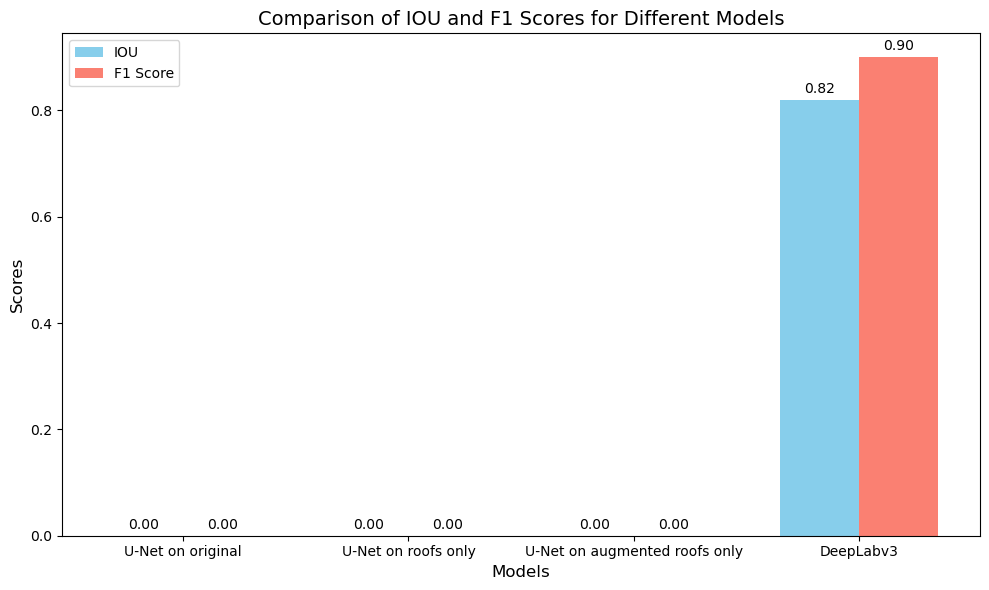

In [20]:
models = ['U-Net on original', 'U-Net on roofs only', 'U-Net on augmented roofs only', 'DeepLabv3']
iou_scores = [original_iou, roof_iou, augmented_iou, 0.82]
f1_scores = [original_f1, roof_f1, augmented_f1, 0.90]

compare_model_metrics(models, iou_scores, f1_scores)